In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

In [4]:
# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [73]:
CSV_PATH="/Users/peterpriestley/hmf/analyses/freecAnalysis/freecVersionCompare/freec-degree-10.2/"
#CSV_PATH="/Users/peterpriestley/hmf/analyses/161209_freeCSliceAnalysis/"
# SPECIFY SAMPLES
CSV_FILENAMES=[]
for x in os.listdir(CSV_PATH):
    if x[-9:] == ".bam_CNVs":
        CSV_FILENAMES.append(x)

#CSV_FILENAMES = ["CPCT02020357T_dedup.realigned.bam_CNVs"]
#CSV_FILENAMES = CSV_FILENAMES[:10]
CSV_FILENAMES

['CPCT02030250T_dedup.realigned.bam_CNVs']

In [74]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [75]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [76]:
def cnvChart(dfCNV,filename):
    plt.figure(figsize=[18,4])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([1, 25, 0, 8])
       

In [77]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [78]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

### ANALYSIS

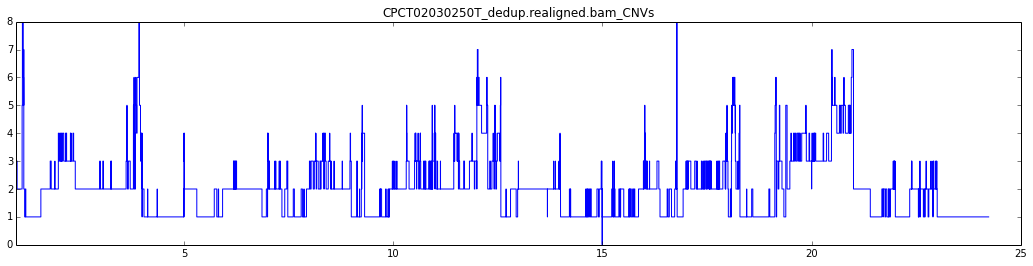

In [79]:
dfAllCNV=pd.DataFrame()
dfAllGeneCNV=pd.DataFrame()
for filename in CSV_FILENAMES:
    patientName=filename[:12]
    dfCNV = loadCNVforPatient(CSV_PATH+filename,patientName)
    dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfCNV,bed,patientName),columns= GENECNV_COLUMNS)
    cnvChart(dfCNV,filename)
    dfAllCNV=pd.concat([dfAllCNV,dfCNV])
    dfAllGeneCNV=pd.concat([dfAllGeneCNV,dfGeneCNV])
dfAllCNV = loadHealthChecksAndMerge(dfAllCNV)
dfAllGeneCNV = loadHealthChecksAndMerge(dfAllGeneCNV)

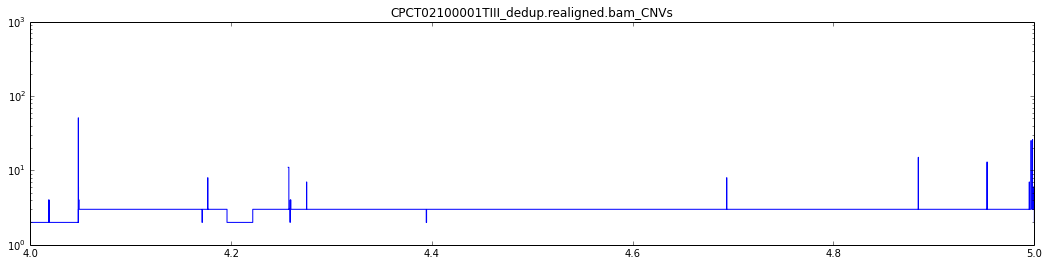

In [16]:
cnvChart(dfCNV,filename)

### LOSS

In [465]:
pd.pivot_table(dfAllGeneCNV[dfAllGeneCNV.cnvLabel=='loss'], values='cnvLabel', index=['gene','chrom'], \
               columns=['TUMOR_TYPE'], aggfunc='count',margins=True).fillna("").\
               sort_values('All',ascending=False)

,TUMOR_TYPE,Unknown,All
gene,chrom,,
All,,9.0,9.0
AMER1,X,1.0,1.0
AR,X,1.0,1.0
ATRX,X,1.0,1.0
KDM5C,X,1.0,1.0
KDM6A,X,1.0,1.0
MED12,X,1.0,1.0
PHF6,X,1.0,1.0
STAG2,X,1.0,1.0


### AMPLIFCATION

In [466]:
pd.pivot_table(dfAllGeneCNV[dfAllGeneCNV.minCopyNum>2], values='cnvLabel', index=['gene','chrom'], \
               columns=['TUMOR_TYPE'], aggfunc='count',margins=True).fillna("").sort_values('All',ascending=False)

,TUMOR_TYPE,Unknown,All
gene,chrom,,
AKT1,14,1.0,1.0
All,,1.0,1.0


### CDF of Gain / Loss

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:2536: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=125869000.0, right=125869000.0
  + 'left=%s, right=%s') % (left, right))


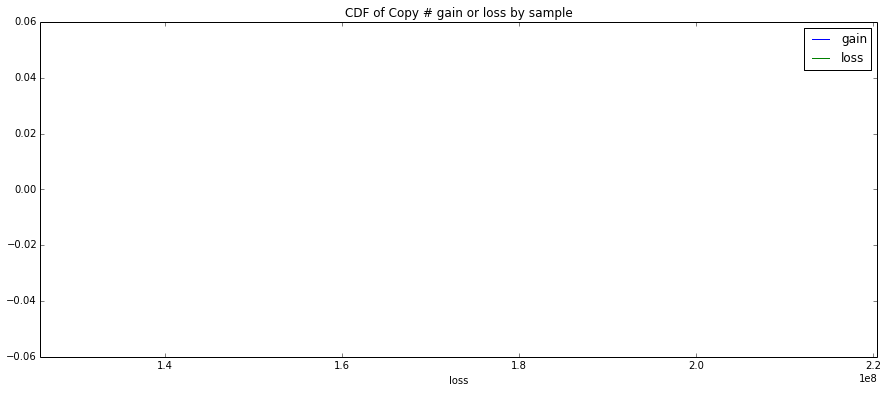

In [467]:
dfGainOrLoss = pd.pivot_table(dfAllCNV[dfAllCNV.gainOrLoss<>'none'], values='regionLength', index=['patientName'], columns=['gainOrLoss'], aggfunc='sum').fillna("")
#Alllele Freq By Caller
for columnName in ['gain','loss']:
    ser = dfGainOrLoss[columnName]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=columnName)
    ser_cdf.plot(drawstyle='steps',legend=True,title="CDF of Copy # gain or loss by sample",figsize=[15,6])

In [468]:
dfGainOrLoss.head(5)

gainOrLoss,gain,loss
patientName,,
CPCT02060041,125869000,220432842


### Read Ratio Analysis by Chromsome

In [21]:
CSV_PATH_INDIVIDUAL="/Users/peterpriestley/hmf/analyses/freecAnalysis/freecVersionCompare/freec-degree-10.2/"
CPN_SAMPLE = "CPCT02030250"
NORMAL_CPN = CPN_SAMPLE + "R_dedup.realigned.bam_control.cpn"
TUMOR_CPN = CPN_SAMPLE + "T_dedup.realigned.bam_sample.cpn"
dfCPNTumor = pd.read_table(CSV_PATH_INDIVIDUAL + TUMOR_CPN, names = ['chrom','window',"copyNum"] )
dfCPNNormal = pd.read_table(CSV_PATH_INDIVIDUAL + NORMAL_CPN, names = ['chrom','window',"copyNum"] )
dfCPNNormal.set_index(['chrom','window'],inplace=True)
dfCPNTumor.set_index(['chrom','window'],inplace=True)
dfCPNTumor = pd.merge(dfCPNTumor,dfCPNNormal,how='inner', left_index=True,right_index=True)
dfCPNTumor = dfCPNTumor[(dfCPNTumor.copyNum_y > 0)]
dfCPNTumor['ratio']= dfCPNTumor['copyNum_x'] /dfCPNTumor['copyNum_y']
dfCPNTumor = dfCPNTumor.reset_index()
dfCPNTumor['chromPos'] = dfCPNTumor['chrom'].apply(lambda x: cd.intChrom(str(x))) + \
    dfCPNTumor['window']/dfCPNTumor['chrom'].map(lambda x: cd.chromosomeLength[str(x)])

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


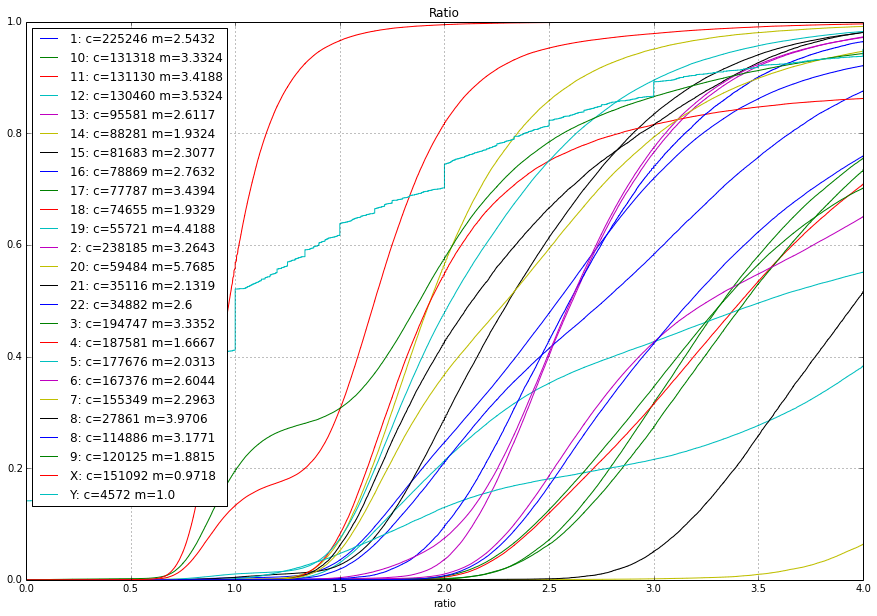

In [22]:
NORM = 1# manually determined from chart
chromosomes = dfCPNTumor['chrom'].unique()
for chromosome in chromosomes:
    ser = dfCPNTumor[dfCPNTumor.chrom==chromosome]['ratio'] / NORM
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome)+": c="+str(ser.count())+" m="+str(round(ser.median(),4)))
    ser_cdf.plot(drawstyle='steps',legend=True, title="Ratio",figsize=[15,10],xlim=[0,4],ylim=[0,1],grid=True)

In [346]:
def readCountChart(dfCPNTumor,chromosomeStart,chromosomeEnd,maxCopyNum=8):
    plt.figure(figsize=[18,5])
    plt.title("readCounts")
    ax = plt.gca()
    ax.plot(dfCPNTumor['chromPos'],dfCPNTumor['copyNum_x'],drawstyle="steps-post")
    ax.plot(dfCPNTumor['chromPos'],dfCPNTumor['copyNum_y'],drawstyle="steps-post")
    #ax.set_yscale('log')
    ax.axis([chromosomeStart, chromosomeEnd,0, maxCopyNum])

In [152]:
def cpnChart(dfCPNTumor,chromosomeStart,chromosomeEnd,normalisation=1,purity=1,maxCopyNum=1000):
    plt.figure(figsize=[18,5])
    plt.title("copyNumberRatio")
    ax = plt.gca()
    ax.plot(dfCPNTumor['chromPos'], (dfCPNTumor['ratio']/normalisation-2.0)/purity+2.0,drawstyle="steps-post")
    #ax.set_yscale('log')
    ax.axis([chromosomeStart, chromosomeEnd,0, maxCopyNum])

In [127]:
dfCNV.head()

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,chromPos,cappedCopyNum,regionLength,patientName
0,0,1,0,3700000,3,gain,1.000000,3,3700000,CPCT02030250
1,451,1,3700000,33442999,2,none,1.014844,2,29742999,CPCT02030250
2,1,1,33443000,35137000,5,gain,1.134174,5,1694000,CPCT02030250
3,2,1,35137000,40289000,8,gain,1.140971,5,5152000,CPCT02030250
4,3,1,40289000,42531000,6,gain,1.161641,5,2242000,CPCT02030250


In [158]:
#dfCPNTumor['ratio']= dfCPNTumor['copyNum_x'] / (-1.75231e-11*dfCPNTumor['copyNum_y']**3 + \
#                                1.68274e-05*dfCPNTumor['copyNum_y']**2 + 0.298907*dfCPNTumor['copyNum_y']**1) 
dfCPNTumor['ratio']= (dfCPNTumor['copyNum_x']-0) / (dfCPNTumor['copyNum_y']**1+300) 

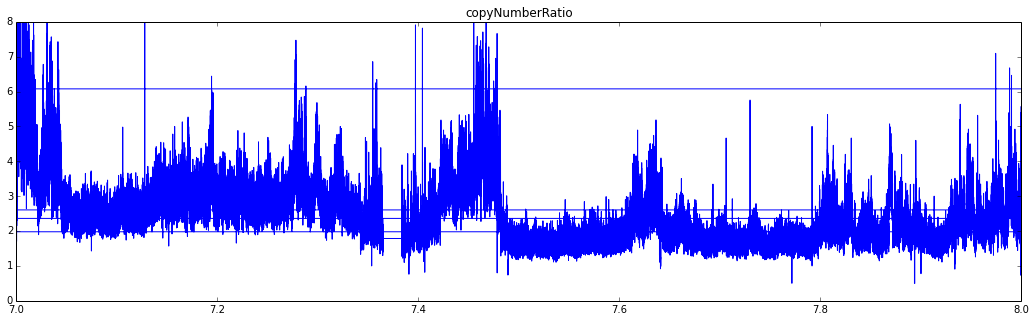

In [274]:
dfCPNTumor['ratio']= (dfCPNTumor['copyNum_x']-0) / (dfCPNTumor['copyNum_y']**1)
cpnChart(dfCPNTumor,7,8,1,1,8)

In [ ]:
dfCPNTumor['copyNum_y'].quantile([0.1,0.25,0.75,0.9])

In [169]:
myMean = dfCPNTumor['copyNum_y'].mean()

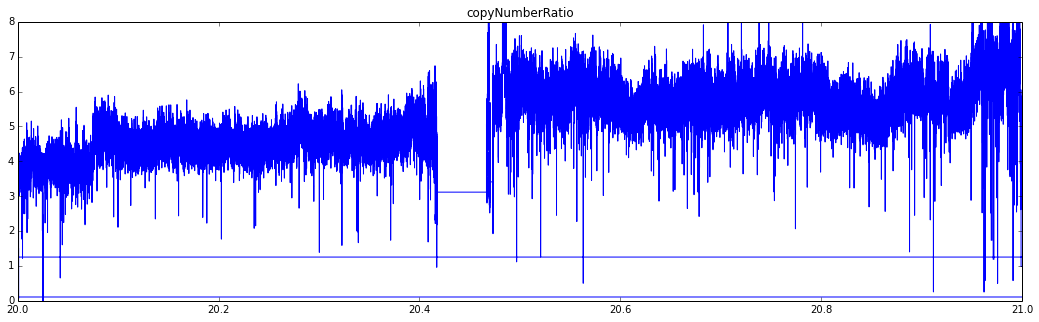

In [306]:
#def rebase(x):
#    return (x - min(100,max(-100,0.5*(x-myMean))))
#dfCPNTumor['ratio']= (dfCPNTumor['copyNum_x']-0) / dfCPNTumor['copyNum_y'].apply(lambda x: rebase(x))
cpnChart(dfCPNTumor,20,21,1,1,8)

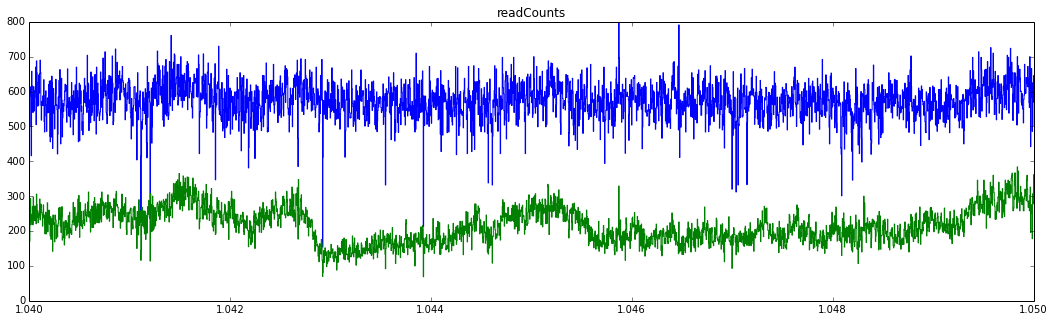

In [348]:
readCountChart(dfCPNTumor,1.04,1.05,800)

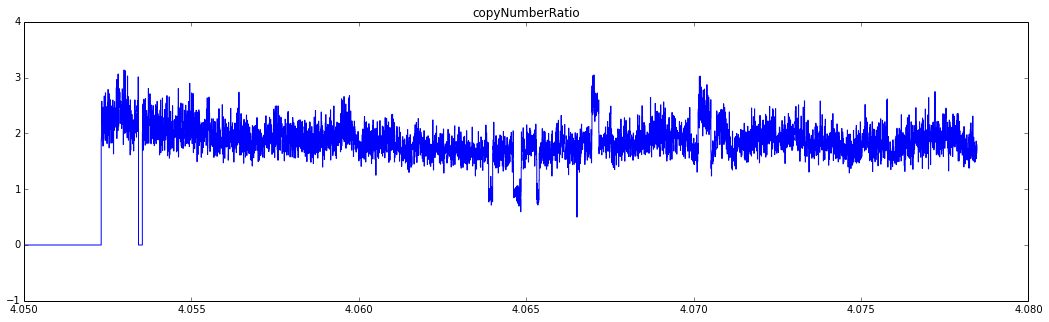

In [82]:
cpnChart(dfCPNTumor,4.05,4.08,1,1,4)

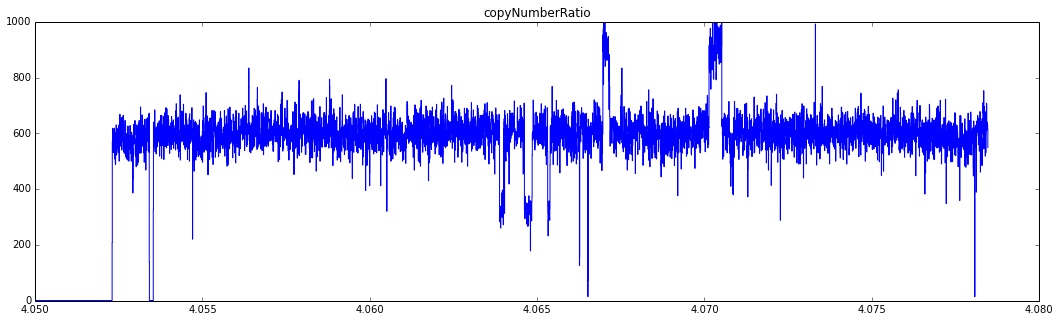

In [78]:
cpnChart(dfCPNTumor,4.05,4.08,1,1,1000)

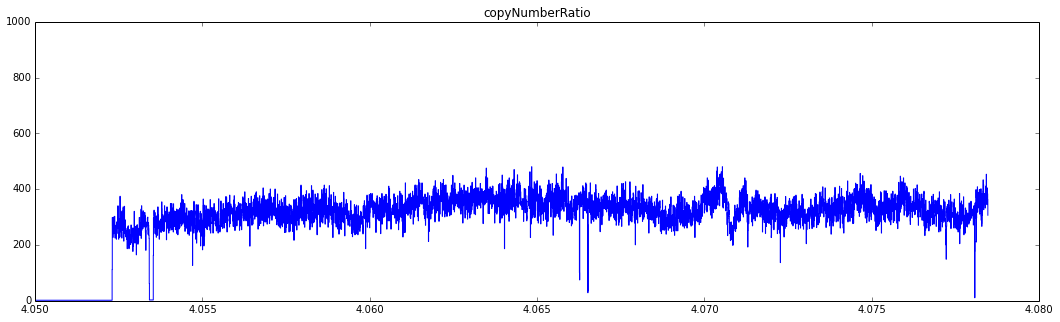

In [76]:
cpnChart(dfCPNTumor,4.05,4.08,1,1,1000)

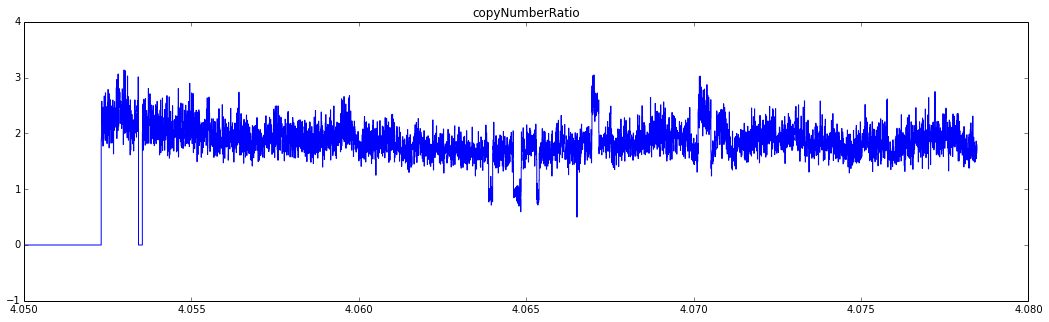

In [57]:
cpnChart(dfCPNTumor,4.05,4.08,1,1,4)

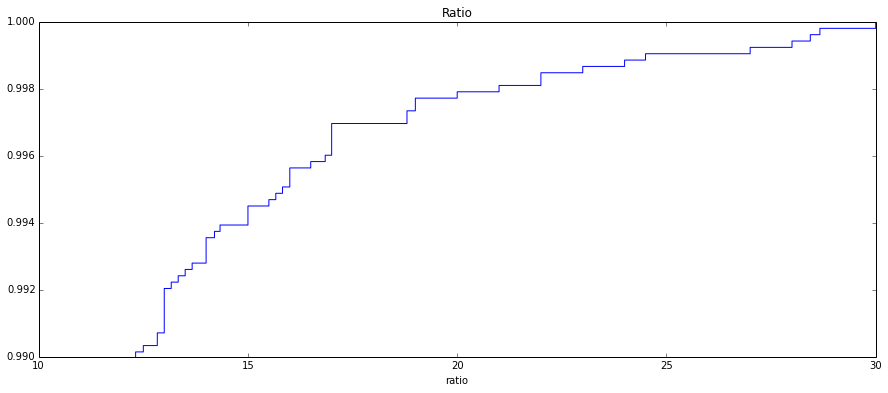

In [396]:
ser_cdf.plot(drawstyle='steps',title="Ratio",figsize=[15,6],xlim=[10,30],ylim=[0.99,1])

In [418]:
dfCPNTumor[['chrom','copyNum_x','copyNum_y']].groupby(['chrom']).agg('sum')/1e6

,copyNum_x,copyNum_y
chrom,,
1,205.322955,63.188465
2,290.067574,72.255228
3,170.840250,58.246599
4,138.839328,63.766397
5,133.174496,53.556602
6,195.212232,51.125292
7,204.847865,44.873865
8,22.835897,6.967850
10,129.713196,41.523548


In [419]:
dfCPNTumor['ratio'].mean()

3.8326996010085339

In [420]:
len(dfCPNTumor[dfCPNTumor['ratio']>2])

2358179

In [478]:
import subprocess
p = subprocess.Popen(["samtools", "faidx"], stdout=subprocess.PIPE)
output, err = p.communicate()
print "*** Running ls -l command ***\n", output

OSError: [Errno 2] No such file or directory

In [2]:
from pyfaidx import Fasta
genes = Fasta('/Users/peterpriestley/hmf/data/refgenomes/Homo_sapiens.GRCh37.GATK.illumina/Homo_sapiens.GRCh37.GATK.illumina.fasta')    
genes[2][25000000:25000100][:100]